# Optiver Trading at the Close
### Project in DD2424

Authors: Alex Lövgren, Hugo Brunlid, Jacob Gustavsson

Date: 2024-05-24

In this file, we create perform feature engineering and create multiple deep architectures using PyTorch with inspiration from [GitHub](https://github.com/nimashahbazi/optiver-trading-close/blob/master/optiver-no-fe-lstm-inference-cleanup.ipynb) by nimashahbazi.

### Import Packages

In [20]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from tqdm import tqdm
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

import torch
from torch import nn
from torch import optim # type: ignore
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from catboost import CatBoostRegressor, Pool

### Setup Device-Agnostic Code

In [21]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = "cpu"
device

'mps'

### Check Directory

In [3]:
!ls

1main.ipynb                       Models
2conv.ipynb                       feature_importance.csv
3lstm.ipynb                       feature_importance.png
4transformer.ipynb                info_df.csv
5featureeng.ipynb                 optiver-trading-at-the-close.zip
6newloss.ipynb                    optiver2023
DD2424_Project_Proposal.pdf       public_timeseries_testing_util.py
Datasets


### Functions for saving and loading models

In [3]:
# Create the directory if it doesn't exist
def save_pickle(data, file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the pickle file
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)

    print(f"Data saved to {file_path}")

# Load and return the data from the pickle file
def load_pickle(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
        return data
    else:
        raise FileNotFoundError(f"No such file: {file_path}")

### Helper Functions

In [ ]:
def plot_losses(train_loss, test_loss, batch_mod, ymin, ymax):
    num_batches = len(train_loss)
    test_loss_indices = list(range(0, num_batches + 1, batch_mod))[:len(test_loss)]

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_batches + 1), train_loss, label='Train Loss')
    plt.plot(test_loss_indices, test_loss, label='Test Loss')
    
    plt.title('Train and Test Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.ylim(ymin, ymax)
    plt.legend()
    plt.show()

In [5]:
def convert_price_cols_float32(df):
    # Columns containing 'price'
    price_columns = [col for col in df.columns if 'price' in col]
    df[price_columns] = df[price_columns].astype('float32')

    # Columns containing 'wap'
    wap_columns = [col for col in df.columns if 'wap' in col]
    df[wap_columns] = df[wap_columns].astype('float32')

    return df

### Load Train and Test Data

In [22]:
train_path = 'Datasets/train.csv'
test_path = 'Datasets/test.csv'

# Load training data and fill missing targets
train = pd.read_csv(train_path).drop(['row_id', 'time_id'], axis=1)
nan_count = train['target'].isna().sum()
print(f"The 'target' column has {nan_count} NaN values.")

target_median = train['target'].median()
#train['target'].fillna(target_median, inplace=True)
train.loc[train['target'].isna(), 'target'] = target_median

print(f"Converting prices columns to float32 values.")
train = convert_price_cols_float32(train)

original_cols = [feature for feature in train.columns]

The 'target' column has 88 NaN values.
Converting prices columns to float32 values.


### Functions for Feature Engineering

In [23]:
"""Feature Engineering: Develop new features based on original columns"""
def feature_engineering(df):
    df = df.copy()

    df['spread_eng'] = df['ask_price'] - df['bid_price'] 
    df['volume_eng'] = df['bid_size'] + df['ask_size']  
    df['volume_imbalance_eng'] = df['bid_size'] - df['ask_size']  
    df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']
    df['price_spread_near_far'] = df['near_price'] - df['far_price']
    df['price_wap_difference_eng'] = df['reference_price'] - df['wap']
    df['weighted_imbalance_eng'] = df['imbalance_size'] * df['imbalance_buy_sell_flag'] # Very important
    
    df['bid_ask_ratio'] = df['bid_size'] / df['ask_size']
    df['imbalance_to_bid_ratio_eng'] = df['imbalance_size'] / df['bid_size']
    df['imbalance_to_ask_ratio_eng'] = df['imbalance_size'] / df['ask_size']
    df['matched_size_to_total_size_ratio_eng'] = df['matched_size'] / (df['bid_size'] + df['ask_size'])

    return df

"""Feature Engineering: Computes the differences and imbalances for pairs of columns"""
def compute_imbalances(df_, columns, prefix = ''):
    df = df_.copy()
    for col1, col2 in combinations(columns, 2):

        # Sort the columns lexicographically to ensure consistent ordering
        col1, col2 = sorted([col1, col2])

        # Compute imbalance directly without creating a temporary difference column
        total = df[col1] + df[col2]
        imbalance_column_name = f'{col1}_{col2}_imb{prefix}'

        # Ensure we don't divide by zero
        df[imbalance_column_name] = (df[col1] - df[col2]).divide(total, fill_value=np.nan)

    return df

"""Feature Engineering: Create lagged difference features for selected columns"""
def create_diff_lagged_features_within_date(df, columns_to_lag, numbers_of_lag):
    df_copy = df.copy()
    new_columns = []

    # Iterate through each specified lag
    for lag in numbers_of_lag:
        # Create lagged dataframe once per lag value
        lagged_df = df.groupby(['stock_id', 'date_id'])[columns_to_lag].shift(periods=lag)
        
        # Iterate through each specified column
        for column in columns_to_lag:
            # Compute the new column
            new_col_name = f'{column}_diff_lag{lag}'
            new_column = df[column] - lagged_df[column]
            
            # Store the new column in the list
            new_columns.append(new_column.rename(new_col_name))

    # Concatenate the original dataframe with the new columns
    result_df = pd.concat([df_copy] + new_columns, axis=1)
    
    return result_df

"""Feature Engineering: Create cumulative sum features for selected columns"""
def create_cumsum_features(df, columns_to_compute):
    df_copy = df.copy()
    
    # Group by 'stock_id' and 'date_id' for cumulative sum calculation
    grouped = df_copy.groupby(['stock_id', 'date_id'])
    
    # Calculate cumulative sum for each column within each group
    for column in columns_to_compute:
        cumsum_col_name = f'{column}_cumsum'
        df_copy[cumsum_col_name] = grouped[column].cumsum()
    return df_copy

"""Feature Engineering: Create deviation features for selected columns"""
def create_deviation_within_seconds(df, num_features):
    groupby_cols = ['date_id', 'seconds_in_bucket']
    new_columns = {}  # Dictionary to hold new columns

    for feature in num_features:
        grouped_median = df.groupby(groupby_cols)[feature].transform('median')
        deviation_col_name = f'deviation_from_median_{feature}'
        new_columns[deviation_col_name] = df[feature] - grouped_median

    # Concatenate all new columns at once
    df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)
    return df

"""Feature Engineering: Lags selected columns by a set number of days"""
def lag_function(df, columns_to_lag, numbers_of_days_to_lag):

    df_indexed = df.set_index(['stock_id', 'seconds_in_bucket', 'date_id'])

    for column_to_lag in columns_to_lag:
        for number_days_to_lag in numbers_of_days_to_lag:
            df_indexed[f'lag{number_days_to_lag}_{column_to_lag}'] = df_indexed.groupby(level=['stock_id', 'seconds_in_bucket'])[column_to_lag].shift(number_days_to_lag)

    df_indexed.reset_index(inplace=True)

    return df_indexed

"""Feature Engineering: Calculate statistics for lagged features"""
def calculate_stat_lag(df, num_lags):
    lags = [f'lag{i}_target' for i in range(1, num_lags + 1)]

    df['target_mean'] = df[lags].mean(axis=1)
    df['target_std_dev'] = df[lags].std(axis=1)
    df['target_variance'] = df[lags].var(axis=1)
    df['target_median'] = df[lags].median(axis=1)
    df['target_range'] = df[lags].max(axis=1) - df[lags].min(axis=1)

    return df

"""Pipeline function for feature engineering"""
def feature_pipeline_eng(df, target_lags, diff_lags, raw_cols, columns_sizes, columns_prices):
    if df.empty:
        return pd.DataFrame()

    # Perform feature engineering
    df = feature_engineering(df)

    # Compute imbalance features
    df = compute_imbalances(df, columns_sizes,prefix='_sz_')
    df = compute_imbalances(df, columns_prices,prefix = '_pr_')

    # Categorize columns
    eng_features       = [feat for feat in df.columns if "_eng" in feat]
    imb_features_size  = [feat for feat in df.columns if "_sz_" in feat]

    # Create lagged features within each date
    diff_lag_cols = raw_cols + eng_features
    df = create_diff_lagged_features_within_date(df, diff_lag_cols, diff_lags)

    # Create cumulative features
    cumsum_columns = columns_sizes + imb_features_size + eng_features 
    df = create_cumsum_features(df, cumsum_columns)

    # Create deviation features
    deviation_cols = raw_cols + eng_features + imb_features_size
    df = create_deviation_within_seconds(df, deviation_cols)
    
    # Lag target column for 3 lags
    df = lag_function(df, ['target'], target_lags)

    # Create statistics for lagged features
    df = calculate_stat_lag(df, num_lags=3)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print("Done...")

    return df

"""Pipeline function for data cleaning and imbalance features"""
def feature_pipeline_imb(df, target_lags, columns_sizes, columns_prices):
    if df.empty:
        return pd.DataFrame()

    # Compute imbalance features
    compute_imbalances(df, columns_sizes, prefix='_sz_')
    compute_imbalances(df, columns_prices, prefix = '_pr_')

    df = lag_function(df, ['target'], target_lags)
    print("Done...")

    return df

"""Pipeline function for data cleaning and lagging targets only"""
def feature_pipeline(df, target_lags):
    if df.empty:
        return pd.DataFrame()

    df = lag_function(df, ['target'], target_lags)
    print("Done...")

    return df

### Feature Engineering

In [24]:
FEATURE_ENG = True

# Pipeline for data manipulation
target_lags = [1, 2, 3]  # Days to lag targets
diff_lags = [1, 2, 3]    # Days to lag features

# Columns to use for feature engineering
columns_prices = ['reference_price','far_price','near_price','bid_price','ask_price','wap']
columns_sizes = ['imbalance_size','matched_size','bid_size','ask_size']
raw_cols = columns_prices + columns_sizes + ['imbalance_buy_sell_flag']

# Perform feature engineering
if FEATURE_ENG:
    train_eng = feature_pipeline_eng(train, target_lags, diff_lags, raw_cols, columns_sizes, columns_prices)

    # Feature selection
    feature_importance_df = pd.read_csv('feature_importance.csv')
    top_20 = feature_importance_df['Feature'].values[:40]
    features = list(set(top_20).union(set(original_cols)))

    # Drop all column from train_eng that are not in features
    train_eng = train_eng[features]
else:
    train_eng = feature_pipeline(train, target_lags)

excluded_columns = ['row_id', 'date_id', 'time_id', 'target', 'stock_return', 'stock_id']
features = [col for col in train_eng.columns if col not in excluded_columns]
categorical_features =  ['seconds_in_bucket']
numerical_features = [feat for feat in features if feat not in categorical_features]
print(f"We have {len(numerical_features)} numerical and {len(categorical_features)} categorical")

rnn_scaler = StandardScaler()
rnn_medians = train_eng.median()

# Fill missing values and normalize numerical features
train_eng.fillna(rnn_medians, inplace=True)
train_eng[numerical_features] = rnn_scaler.fit_transform(train_eng[numerical_features])

rnn_all_data = {
  "rnn_scaler": rnn_scaler,
  "rnn_medians": rnn_medians,
  "categorical_features": categorical_features,
  "numerical_features": numerical_features
}

print(train_eng.shape)
train_eng

Done...
We have 45 numerical and 1 categorical
(5237980, 49)


,wap,deviation_from_median_reference_price,deviation_from_median_imbalance_size_matched_size_imb_sz_,ask_price_reference_price_imb_pr_,target_mean,ask_size_matched_size_imb_sz__cumsum,matched_size_to_total_size_ratio_eng,matched_size_cumsum,stock_id,ask_price_wap_imb_pr_,...,deviation_from_median_price_wap_difference_eng,matched_size,deviation_from_median_near_price,far_price,ask_price_bid_price_imb_pr_,deviation_from_median_wap,price_wap_difference_eng_cumsum,deviation_from_median_spread_eng,bid_ask_ratio,date_id
0,0.003222,-0.072113,-0.758544,-0.126007,-0.000818,1.680802,-0.153009,-0.258132,0,-0.661211,...,-0.336964,-0.226823,0.012339,-0.001697,-0.556042,-0.009900,-0.034116,-0.950125,-0.013600,0
1,0.003222,-0.031731,-1.427303,1.133947,-0.000818,1.682294,-0.170578,-0.260894,1,1.038806,...,-0.119487,-0.310763,0.012339,-0.001697,0.386886,-0.009900,-0.023583,0.026155,-0.125675,0
2,0.003222,-0.192801,-1.088670,1.072806,-0.000818,1.682033,-0.175786,-0.260852,2,0.068413,...,-0.986926,-0.309496,0.012339,-0.001697,0.612294,-0.009900,-0.065594,0.258825,-0.096128,0
3,0.003222,0.100478,0.587499,-0.517857,-0.000818,1.683944,-0.174904,-0.256953,3,-0.156976,...,0.592522,-0.191000,0.012339,-0.001697,-0.554373,-0.009900,0.010900,-0.948326,-0.128115,0
4,0.003222,-0.206759,-1.880026,0.493037,-0.000818,1.680725,-0.031470,-0.257078,4,-0.688073,...,-1.062094,-0.194784,0.012339,-0.001697,0.144041,-0.009900,-0.069234,-0.225877,0.481189,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,0.134534,0.341653,0.103469,-0.348272,-0.688101,-1.728802,-0.168967,-0.036050,195,-0.446425,...,-0.032666,-0.120271,0.035511,-0.002005,-0.722381,0.379686,-0.432463,-0.417440,-0.126574,480
5237976,0.331143,0.498424,-0.182912,-0.027870,-0.846503,-1.685329,-0.175951,-0.185740,196,-0.513658,...,-0.459903,-0.256805,0.118077,-0.001187,-0.482598,0.620777,-0.849200,-0.169006,-0.092952,480
5237977,-1.679699,-1.835572,-0.428118,-0.400138,0.071886,-1.682115,-0.171175,-0.157806,197,-0.499236,...,-0.024949,-0.231506,-0.464052,-0.010180,-0.761196,-1.845009,-0.392381,-0.458387,-0.126696,480
5237978,-0.393982,-0.190623,-0.358193,-0.616469,0.459654,-1.722500,-0.163495,0.752088,198,-0.188569,...,0.518821,0.355227,-0.030842,-0.003091,-0.511020,-0.268404,0.182516,-0.199160,-0.125183,480


In [53]:
# View model features
pd.DataFrame({
    'Feature': categorical_features + numerical_features,
    'Type': ['Categorical'] * len(categorical_features) + ['Numerical'] * len(numerical_features)
})

,Feature,Type
0,seconds_in_bucket,Categorical
1,wap,Numerical
2,deviation_from_median_reference_price,Numerical
3,deviation_from_median_imbalance_size_matched_s...,Numerical
4,ask_price_reference_price_imb_pr_,Numerical
5,target_mean,Numerical
6,ask_size_matched_size_imb_sz__cumsum,Numerical
7,matched_size_to_total_size_ratio_eng,Numerical
8,matched_size_cumsum,Numerical
9,ask_price_wap_imb_pr_,Numerical


### Feature Importance

Evaluate the importance of different features, using the entire set of engineered features.

0:	learn: 9.4326062	total: 642ms	remaining: 10m 41s
100:	learn: 9.2328343	total: 32.1s	remaining: 4m 46s
200:	learn: 9.1795576	total: 1m 2s	remaining: 4m 9s
300:	learn: 9.1413562	total: 1m 32s	remaining: 3m 35s
400:	learn: 9.1094459	total: 2m 3s	remaining: 3m 5s
500:	learn: 9.0823362	total: 2m 33s	remaining: 2m 32s
600:	learn: 9.0589079	total: 3m 3s	remaining: 2m 1s
700:	learn: 9.0373004	total: 3m 33s	remaining: 1m 31s
800:	learn: 9.0168454	total: 4m 3s	remaining: 1m
900:	learn: 8.9987390	total: 4m 32s	remaining: 29.9s
999:	learn: 8.9820341	total: 5m 2s	remaining: 0us


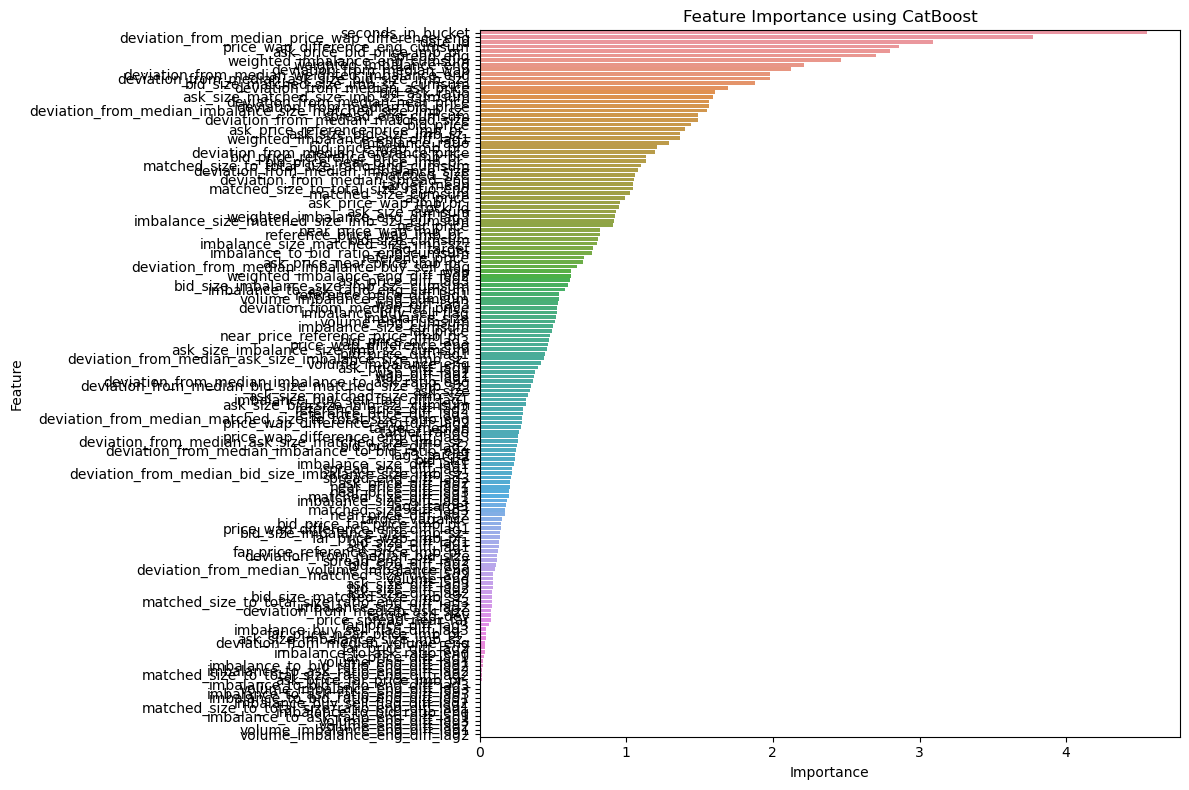

In [25]:
# Split the dataframe into features and target
X = train_eng.drop(columns=['target'])
y = train_eng['target']

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=100)
model.fit(X, y)

# Get feature importance
feature_importances = model.get_feature_importance()
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance using CatBoost')
plt.tight_layout()
plt.show()

In [27]:
# Save the feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_df.to_csv('feature_importance.csv', index=False)
feature_importance_df

,Feature,Importance
0,seconds_in_bucket,4.549702
1,deviation_from_median_price_wap_difference_eng,3.776997
2,date_id,3.092683
3,price_wap_difference_eng_cumsum,2.859626
4,ask_price_bid_price_imb_pr_,2.796578
...,...,...
149,imbalance_to_ask_ratio_eng_diff_lag1,0.004975
150,volume_eng_diff_lag3,0.004107
151,volume_eng_diff_lag2,0.004059
152,volume_imbalance_eng_diff_lag1,0.000000


### Split into training and testing data

In [10]:
"""Extract a subset of data based on a specified date range"""
def split_by_date(df, dates):
    df_start, df_end = dates
    df = df[(df['date_id'] >= df_start) & (df['date_id'] <=df_end)].reset_index(drop=True)

    return df

In [25]:
# Choose dates for training and validation
dates_train = [0,250]       # [0,390]
dates_test = [251,300]      # [391,480]

# Split train and test data by date
train_data = split_by_date(train_eng, dates_train)
test_data = split_by_date(train_eng, dates_test)
print(f"Number of dates in train {train_data['date_id'].nunique()}")
print(f"Number of dates in test {test_data['date_id'].nunique()}")

# Cleanup using garbage collector
del train_eng, train
gc.collect()

Number of dates in train 251
Number of dates in test 50


0

### Preprocessing data into batches

In [26]:
"""Precomputes sequences of data"""
def precompute_sequences(stock_data, window_size, numerical_features, categorical_features):
    # Convert DataFrame columns to NumPy arrays
    stock_data_num = stock_data[numerical_features].values
    stock_data_cat = stock_data[categorical_features].values

    # Pre-compute all sequences
    all_sequences_num = [stock_data_num[max(0, i - window_size + 1):i + 1] for i in range(len(stock_data))]
    all_sequences_cat = [stock_data_cat[max(0, i - window_size + 1):i + 1] for i in range(len(stock_data))]

    # Add padding if necessary
    padded_sequences_num = [np.pad(seq, ((window_size - len(seq), 0), (0, 0)), 'constant') for seq in all_sequences_num]
    padded_sequences_cat = [np.pad(seq, ((window_size - len(seq), 0), (0, 0)), 'constant') for seq in all_sequences_cat]

    # Combine numerical and categorical features
    combined_sequences = np.array([np.concatenate([num, cat], axis=-1)
                                   for num, cat in zip(padded_sequences_num, padded_sequences_cat)])

    # Extract targets
    targets = stock_data['target'].values

    return combined_sequences, targets

"""Creates batches of data"""
def create_batches(data, window_size, numerical_features, categorical_features, max_time_steps=55):

    grouped = data.groupby(['stock_id', 'date_id'])
    all_batches = []
    all_targets = []

    for _, group in tqdm(grouped, desc="Processing groups"):
        # Precompute sequences for the current group
        precomputed_data = precompute_sequences(group, window_size, numerical_features, categorical_features)

        # Initialize containers for group sequences and targets
        group_sequences = []
        group_targets = []

        # Iterate over the time steps and retrieve precomputed sequences
        for time_step in range(max_time_steps):
            # Get sequence
            combined_sequences, targets = precomputed_data
            sequence, target = combined_sequences[time_step], targets[time_step]

            if sequence.size > 0:
                group_sequences.append(sequence)
                group_targets.append(target)

        # Extend the main batches with the group's sequences and targets
        all_batches.extend(group_sequences)
        all_targets.extend(group_targets)

    return all_batches, all_targets

"""Prepares input data as batches"""
def second_pass_for_rnn(df, numerical_features, categorical_features, window_size, is_inference=False):
    # Check if the DataFrame is empty
    global rnn_scaler,rnn_medians

    # Work on a copy of the DataFrame to avoid changing the original df
    df_copy = df.copy()

    # Preprocess Data
    df_copy['seconds_in_bucket'] = df_copy['seconds_in_bucket'] / 10
    df_copy['imbalance_buy_sell_flag'] += 1

    df_copy_batches, df_copy_targets = create_batches(df_copy, window_size, numerical_features, categorical_features)

    df_copy_batches = np.array(df_copy_batches)
    df_copy_targets = np.array(df_copy_targets)

    return df_copy_batches, df_copy_targets

window_size = 3

train_batches, train_targets = second_pass_for_rnn(train_data, numerical_features, categorical_features, window_size)
test_batches, test_targets = second_pass_for_rnn(test_data, numerical_features, categorical_features, window_size)

Processing groups: 100%|██████████| 9956/9956 [00:11<00:00, 833.96it/s]


### Make batches compatible with Pytorch

In [27]:
"""Convert data to torch.tensor and put on device"""
class StockDataset(Dataset):
    def __init__(self, sequences, targets, device):
        self.sequences = torch.tensor(sequences, dtype=torch.float32).to(device)
        self.targets = torch.tensor(targets, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

batch_size = 2**12

train_dataset = StockDataset(train_batches, train_targets, device)
test_dataset = StockDataset(test_batches, test_targets, device)

train_loader = DataLoader(train_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

del train_batches, train_targets, test_batches, test_targets
gc.collect()

49

In [52]:
# Examine the DataLoaders
print(f"Batch size: {test_loader.batch_size}")
print(f"Number of workers: {test_loader.num_workers}")
print(f"Dataset length: {len(test_loader.dataset)}")

# To print details of a few batches:
for i, (data, target) in enumerate(test_loader):
    print(f"Batch {i + 1}:")
    print(f"  Data shape: {data.shape}")
    print(f"  Target shape: {target.shape}")
    if i == 2:  # Print only first 3 batches
        break

Batch size: 4096
Number of workers: 0
Dataset length: 547580
Batch 1:
  Data shape: torch.Size([4096, 3, 46])
  Target shape: torch.Size([4096])
Batch 2:
  Data shape: torch.Size([4096, 3, 46])
  Target shape: torch.Size([4096])
Batch 3:
  Data shape: torch.Size([4096, 3, 46])
  Target shape: torch.Size([4096])


### Training Loop for Models

In [15]:
def train_model(model, eval_model, train_loader, num_epochs, criterion, optimizer, device, eval_size=20):
    train_loss, test_loss = [], []
    temp_loader = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            data, target = data.to(device), target.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs.squeeze(), target)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * data.size(0)
            smooth_loss = running_loss / ((batch_idx + 1) * data.size(0))
            train_loss.append(smooth_loss)

            # Compute loss for test data and append to list
            if batch_idx % eval_size == 0 and batch_idx > 0:
                eval_model.eval()
                cum_loss = 0.0
                with torch.inference_mode():
                    for temp_idx, (data_eval, target_eval) in enumerate(temp_loader):
                        data_eval, target_eval = data_eval.to(device), target_eval.to(device)
                        outputs = eval_model(data_eval)
                        loss = criterion(outputs.squeeze(), target_eval)
                        cum_loss += loss.item() * data_eval.size(0)
                    cum_loss /= (eval_size * data_eval.size(0))
                    if test_loss: 
                        test_loss.append(test_loss[-1] * 0.9 + cum_loss * 0.1)
                    else:
                        test_loss.append(cum_loss)
                eval_model = deepcopy(model)
                temp_loader = []
            else: 
                temp_loader.append((data, target))

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    return model, train_loss, test_loss

## Convolutional Neural Network with Residual Connections

### Model Architecture

In [36]:
class ApplyConvLayers(nn.Module):
    def __init__(self, input_dim, kernel_sizes, filters=16, do_ratio=0.5):
        super(ApplyConvLayers, self).__init__()
        self.kernel_sizes = kernel_sizes
        self.filters = filters
        self.do_ratio = do_ratio

        self.conv_blocks = nn.ModuleList()
        for kernel_size in kernel_sizes:
            conv_block = nn.Sequential(
                nn.Conv1d(in_channels=input_dim, out_channels=filters, kernel_size=kernel_size, padding="same"),
                nn.BatchNorm1d(filters),
                nn.ReLU(),
                nn.Dropout(do_ratio),
                nn.Conv1d(in_channels=filters, out_channels=filters, kernel_size=kernel_size, padding="same"),
                nn.BatchNorm1d(filters),
                nn.ReLU()
            )
            self.conv_blocks.append(conv_block)

        self.addition = nn.ModuleList([nn.Conv1d(in_channels=input_dim, out_channels=filters, kernel_size=1, padding=0) for _ in kernel_sizes])
        self.flatten = nn.Flatten()

    def forward(self, x: torch.Tensor):
        conv_outputs = []
        for i, conv_block in enumerate(self.conv_blocks):
            shortcut = self.addition[i](x)
            conv_output = conv_block(x)
            conv_output = conv_output + shortcut
            conv_outputs.append(conv_output)

        concatenated_conv = torch.cat(conv_outputs, dim=1)
        flattened_conv_output = self.flatten(concatenated_conv)
        return flattened_conv_output

class ConvRNNModel(nn.Module):
    def __init__(self, window_size, numerical_dim, categorical_uniques, embedding_dim, dense_sizes):
        super(ConvRNNModel, self).__init__()

        self.window_size = window_size
        self.categorical_uniques = categorical_uniques
        self.numerical_dim = numerical_dim
        self.embedding_dim = embedding_dim

        # Embedding layer for the categorical feature (seconds_in_bucket)
        self.embedding = nn.Embedding(categorical_uniques, embedding_dim)

        # Apply convolutional layers to numerical input and categorical input (embedding)
        kernel_sizes = [2, 3]
        do_ratio = 0.4

        self.apply_conv_numerical = ApplyConvLayers(numerical_dim, kernel_sizes, filters=16, do_ratio=do_ratio)
        self.apply_conv_embedding = ApplyConvLayers(embedding_dim, kernel_sizes, filters=16, do_ratio=do_ratio)

        # Dense layers
        dense_input_dim = 192    # Matches post ConvLayers concatenated shape.
        self.dense_layers = nn.ModuleList()
        for size in dense_sizes:
            dense_layer = nn.Sequential(
                nn.Linear(dense_input_dim, size),
                nn.BatchNorm1d(size),
                nn.Dropout(do_ratio),
                nn.SiLU()
            )
            self.dense_layers.append(dense_layer)
            dense_input_dim = size

        self.output_layer = nn.Linear(dense_sizes[-1], 1)

    def forward(self, x):
        numerical_input = x[:, :, :-1]
        categorical_input = x[:, :, -1].long()

        # Embedding for categorical input
        embedding = self.embedding(categorical_input).permute(0, 2, 1)

        # Convolutional layers
        flattened_conv_output = self.apply_conv_numerical(numerical_input.permute(0, 2, 1))
        flattened_conv_output_cat = self.apply_conv_embedding(embedding)

        # Concatenate features
        dense_input = torch.cat([flattened_conv_output, flattened_conv_output_cat], dim=1)

        # Dense layers
        for layer in self.dense_layers:
            dense_input = layer(dense_input)

        output = self.output_layer(dense_input)
        return output


### Training ConvNet Model

In [37]:
# Hyperparameters
window_size = 3
categorical_uniques = 55
numerical_dim = len(numerical_features)
embedding_dim = 10
dense_sizes = [512, 256, 128, 64, 32]
initial_learning_rate = 0.001
num_epochs = 15

# Initiate model
model = ConvRNNModel(window_size, numerical_dim, categorical_uniques, embedding_dim, dense_sizes).to(device)
eval_model = ConvRNNModel(window_size, numerical_dim, categorical_uniques, embedding_dim, dense_sizes).to(device)

criterion = torch.nn.L1Loss()                                           # Mean Absolute Error Loss
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)    # Adam Optimizer (no learning rate scheduler)

# Train the model
model, train_loss, test_loss = train_model(model, eval_model, train_loader, num_epochs, criterion, optimizer, device, eval_size=20)

# Save the trained model
torch.save(model.state_dict(), 'Models/conv_model_fe_newloss.pth')

Epoch 1/15:   0%|          | 0/662 [00:00<?, ?it/s]/opt/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1716363481796/work/aten/src/ATen/native/Convolution.cpp:1032.)
  return F.conv1d(input, weight, bias, self.stride,
Epoch 1/15: 100%|██████████| 662/662 [02:02<00:00,  5.39it/s]


Epoch [1/15], Loss: 6.5118


Epoch 2/15: 100%|██████████| 662/662 [02:07<00:00,  5.21it/s]


Epoch [2/15], Loss: 6.4776


Epoch 3/15: 100%|██████████| 662/662 [02:22<00:00,  4.66it/s]


Epoch [3/15], Loss: 6.4634


Epoch 4/15: 100%|██████████| 662/662 [02:29<00:00,  4.44it/s]


Epoch [4/15], Loss: 6.4527


Epoch 5/15: 100%|██████████| 662/662 [02:29<00:00,  4.42it/s]


Epoch [5/15], Loss: 6.4452


Epoch 6/15: 100%|██████████| 662/662 [02:30<00:00,  4.39it/s]


Epoch [6/15], Loss: 6.4383


Epoch 7/15: 100%|██████████| 662/662 [02:31<00:00,  4.36it/s]


Epoch [7/15], Loss: 6.4321


Epoch 8/15: 100%|██████████| 662/662 [02:34<00:00,  4.28it/s]


Epoch [8/15], Loss: 6.4272


Epoch 9/15: 100%|██████████| 662/662 [02:34<00:00,  4.30it/s]


Epoch [9/15], Loss: 6.4231


Epoch 10/15: 100%|██████████| 662/662 [02:35<00:00,  4.25it/s]


Epoch [10/15], Loss: 6.4183


Epoch 11/15: 100%|██████████| 662/662 [02:36<00:00,  4.23it/s]


Epoch [11/15], Loss: 6.4156


Epoch 12/15: 100%|██████████| 662/662 [02:36<00:00,  4.23it/s]


Epoch [12/15], Loss: 6.4116


Epoch 13/15: 100%|██████████| 662/662 [02:35<00:00,  4.25it/s]


Epoch [13/15], Loss: 6.4095


Epoch 14/15: 100%|██████████| 662/662 [02:36<00:00,  4.22it/s]


Epoch [14/15], Loss: 6.4067


Epoch 15/15: 100%|██████████| 662/662 [02:36<00:00,  4.22it/s]

Epoch [15/15], Loss: 6.4038


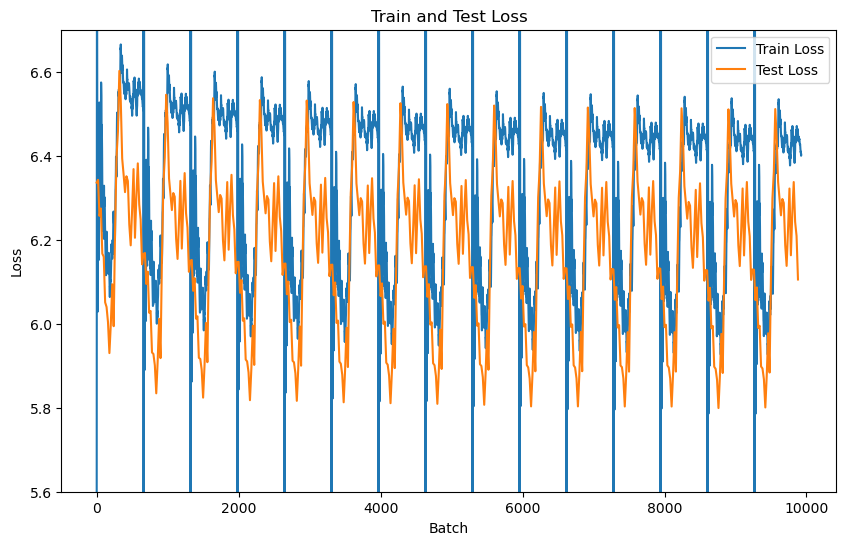

In [38]:
plot_losses(train_loss[4:-1], test_loss, batch_mod=20, ymin=5.6, ymax=6.7)

### Model Summary

In [59]:
batch_data, _ = next(iter(train_loader))    # Returns batch as (data, label)
input_size = batch_data.shape[1:]

# Print model summary
model = ConvRNNModel(window_size, numerical_dim, categorical_uniques, embedding_dim, dense_sizes).to('cpu')
summary(model, input_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                [-1, 3, 11]             605
            Conv1d-2                [-1, 16, 3]             736
            Conv1d-3                [-1, 16, 3]           1,456
       BatchNorm1d-4                [-1, 16, 3]              32
              ReLU-5                [-1, 16, 3]               0
           Dropout-6                [-1, 16, 3]               0
            Conv1d-7                [-1, 16, 3]             528
       BatchNorm1d-8                [-1, 16, 3]              32
              ReLU-9                [-1, 16, 3]               0
           Conv1d-10                [-1, 16, 3]             736
           Conv1d-11                [-1, 16, 3]           2,176
      BatchNorm1d-12                [-1, 16, 3]              32
             ReLU-13                [-1, 16, 3]               0
          Dropout-14                [-1

## Long Short-Term Memory (LSTM)

### Model Architecture

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, window_size, numerical_dim, embedding_dim, dense_sizes):
        super(LSTMModel, self).__init__()

        self.window_size = window_size
        self.categorical_uniques = categorical_uniques
        self.numerical_dim = numerical_dim
        self.embedding_dim = embedding_dim

        # Embedding layer for the categorical feature (seconds_in_bucket)
        self.embedding = nn.Embedding(categorical_uniques, embedding_dim)

        # Define LSTM layers
        self.lstm = nn.LSTM(
            input_size=numerical_dim + embedding_dim,
            hidden_size=64,
            num_layers=2,
            batch_first=True
        )

        # Dense layers
        dense_input_dim = 64
        do_ratio = 0.3
        self.dense_layers = nn.ModuleList()
        for size in dense_sizes:
            dense_layer = nn.Sequential(
                nn.Linear(dense_input_dim, size),
                nn.BatchNorm1d(size),
                nn.Dropout(do_ratio),
                nn.SiLU()
            )
            self.dense_layers.append(dense_layer)
            dense_input_dim = size

        self.output_layer = nn.Linear(dense_sizes[-1], 1)

    def forward(self, x: torch.Tensor):
        numerical_input = x[:, :, :-1]
        categorical_input = x[:, :, -1].long()

        # Embedding for categorical input
        embedding = self.embedding(categorical_input)

        # LSTM layer
        lstm_input = torch.cat([numerical_input, embedding], dim=2)
        lstm_output, _ = self.lstm(lstm_input)

        # Dense layers
        dense_input = lstm_output[:, -1, :]  # Take the last timestep
        for layer in self.dense_layers:
            dense_input = layer(dense_input)

        output = self.output_layer(dense_input)

        return output

### Training LSTM model

In [17]:
# Hyperparameters
window_size = 3
categorical_uniques = 55
numerical_dim = len(numerical_features)
embedding_dim = 10
dense_sizes = [512, 256, 128, 64, 32]
initial_learning_rate = 0.001
num_epochs = 15

train_loss, test_loss = [], []

# Initiate model
model = LSTMModel(window_size, numerical_dim, embedding_dim, dense_sizes).to(device)
eval_model = LSTMModel(window_size, numerical_dim, embedding_dim, dense_sizes).to(device)

criterion = torch.nn.L1Loss()                                           # Mean Absolute Error Loss
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)    # Adam Optimizer (no learning rate scheduler)

# Train the model
model, train_loss, test_loss = train_model(model, eval_model, train_loader, num_epochs, criterion, optimizer, device, eval_size=20)

# Save the trained model
torch.save(model.state_dict(), 'Models/lstm_model_fe_newloss.pth')

Epoch 1/15: 100%|██████████| 662/662 [38:33<00:00,  3.49s/it]    


Epoch [1/15], Loss: 6.4961


Epoch 2/15: 100%|██████████| 662/662 [01:59<00:00,  5.56it/s]


Epoch [2/15], Loss: 6.4543


Epoch 3/15: 100%|██████████| 662/662 [02:02<00:00,  5.41it/s]


Epoch [3/15], Loss: 6.4308


Epoch 4/15: 100%|██████████| 662/662 [02:02<00:00,  5.40it/s]


Epoch [4/15], Loss: 6.4160


Epoch 5/15: 100%|██████████| 662/662 [02:05<00:00,  5.26it/s]


Epoch [5/15], Loss: 6.4071


Epoch 6/15: 100%|██████████| 662/662 [08:47<00:00,  1.26it/s]   


Epoch [6/15], Loss: 6.3993


Epoch 7/15: 100%|██████████| 662/662 [01:58<00:00,  5.58it/s]


Epoch [7/15], Loss: 6.3928


Epoch 8/15: 100%|██████████| 662/662 [01:58<00:00,  5.58it/s]


Epoch [8/15], Loss: 6.3867


Epoch 9/15: 100%|██████████| 662/662 [01:57<00:00,  5.61it/s]


Epoch [9/15], Loss: 6.3812


Epoch 10/15: 100%|██████████| 662/662 [01:59<00:00,  5.53it/s]


Epoch [10/15], Loss: 6.3761


Epoch 11/15: 100%|██████████| 662/662 [02:00<00:00,  5.52it/s]


Epoch [11/15], Loss: 6.3710


Epoch 12/15: 100%|██████████| 662/662 [01:59<00:00,  5.53it/s]


Epoch [12/15], Loss: 6.3660


Epoch 13/15: 100%|██████████| 662/662 [02:00<00:00,  5.51it/s]


Epoch [13/15], Loss: 6.3615


Epoch 14/15: 100%|██████████| 662/662 [02:00<00:00,  5.49it/s]


Epoch [14/15], Loss: 6.3576


Epoch 15/15: 100%|██████████| 662/662 [01:59<00:00,  5.52it/s]

Epoch [15/15], Loss: 6.3534


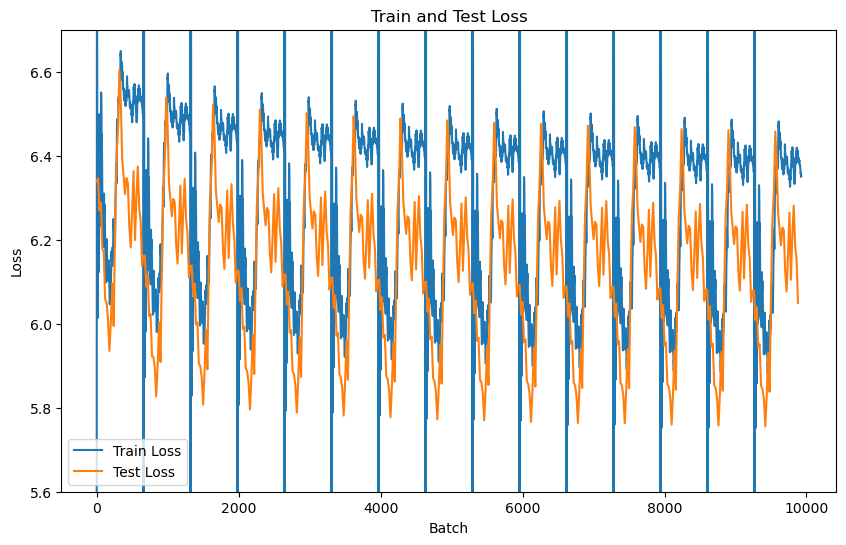

In [18]:
plot_losses(train_loss[4:-1], test_loss, batch_mod=20, ymin=5.6, ymax=6.7)

## Recurrent Neural Networks (RNNs)

### Model Architecture

In [39]:
class RNNModelBase(nn.Module):
    def __init__(self, window_size, numerical_dim, embedding_dim, categorical_uniques, dense_sizes):
        super(RNNModelBase, self).__init__()

        self.window_size = window_size
        self.numerical_dim = numerical_dim
        self.embedding_dim = embedding_dim

        # Embedding layer for the categorical feature
        self.embedding = nn.Embedding(categorical_uniques, embedding_dim)

        # Define RNN layers
        self.rnn = nn.RNN(
            input_size=numerical_dim + embedding_dim,
            hidden_size=100,
            num_layers=2,
            batch_first=True
        )

        self.output_layer = nn.Linear(100, 1)

    def forward(self, x):
        # Split the input tensor into numerical and categorical inputs
        numerical_input = x[:, :, :-1]
        categorical_input = x[:, :, -1].long()

        # Embedding for categorical input
        embedding = self.embedding(categorical_input)

        # RNN layer
        rnn_input = torch.cat([numerical_input, embedding], dim=2)
        rnn_output, _ = self.rnn(rnn_input)

        # Take the output at the last timestep
        last_timestep_output = rnn_output[:, -1, :]

        output = self.output_layer(last_timestep_output)

        return output

### Train RNN model

In [40]:
# Hyperparameters
window_size = 3
categorical_uniques = 55
numerical_dim = len(numerical_features)
embedding_dim = 10
dense_sizes = [512, 256, 128, 64, 32]
initial_learning_rate = 0.01
num_epochs = 15

model = RNNModelBase(window_size, numerical_dim, embedding_dim, categorical_uniques, dense_sizes).to(device)
eval_model = RNNModelBase(window_size, numerical_dim, embedding_dim, categorical_uniques, dense_sizes).to(device)

criterion = torch.nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

# Train the model
model, train_loss, test_loss = train_model(model, eval_model, train_loader, num_epochs, criterion, optimizer, device, eval_size=20)

# Save the trained model
torch.save(model.state_dict(), 'Models/rnn_model_base_fe_newloss.pth')

Epoch 1/15: 100%|██████████| 662/662 [02:08<00:00,  5.15it/s]


Epoch [1/15], Loss: 6.5019


Epoch 2/15: 100%|██████████| 662/662 [02:02<00:00,  5.38it/s]


Epoch [2/15], Loss: 6.4737


Epoch 3/15: 100%|██████████| 662/662 [02:04<00:00,  5.32it/s]


Epoch [3/15], Loss: 6.4646


Epoch 4/15: 100%|██████████| 662/662 [02:02<00:00,  5.41it/s]


Epoch [4/15], Loss: 6.4574


Epoch 5/15: 100%|██████████| 662/662 [01:56<00:00,  5.66it/s]


Epoch [5/15], Loss: 6.4543


Epoch 6/15: 100%|██████████| 662/662 [01:54<00:00,  5.77it/s]


Epoch [6/15], Loss: 6.4531


Epoch 7/15: 100%|██████████| 662/662 [01:54<00:00,  5.76it/s]


Epoch [7/15], Loss: 6.4506


Epoch 8/15: 100%|██████████| 662/662 [01:54<00:00,  5.78it/s]


Epoch [8/15], Loss: 6.4503


Epoch 9/15: 100%|██████████| 662/662 [01:52<00:00,  5.86it/s]


Epoch [9/15], Loss: 6.4482


Epoch 10/15: 100%|██████████| 662/662 [01:58<00:00,  5.58it/s]


Epoch [10/15], Loss: 6.4482


Epoch 11/15: 100%|██████████| 662/662 [10:08<00:00,  1.09it/s]  


Epoch [11/15], Loss: 6.4456


Epoch 12/15: 100%|██████████| 662/662 [06:27<00:00,  1.71it/s]  


Epoch [12/15], Loss: 6.4446


Epoch 13/15: 100%|██████████| 662/662 [01:55<00:00,  5.74it/s]


Epoch [13/15], Loss: 6.4442


Epoch 14/15: 100%|██████████| 662/662 [01:51<00:00,  5.96it/s]


Epoch [14/15], Loss: 6.4448


Epoch 15/15: 100%|██████████| 662/662 [01:51<00:00,  5.92it/s]

Epoch [15/15], Loss: 6.4442


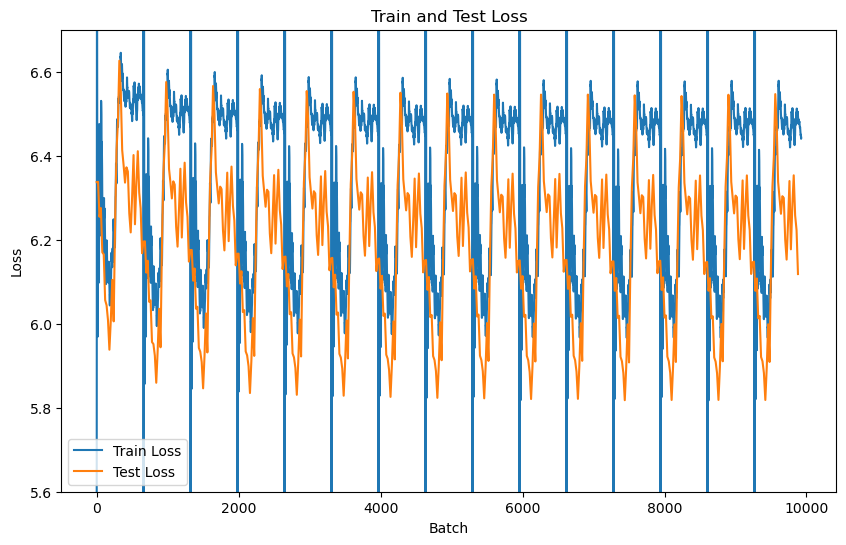

In [41]:
plot_losses(train_loss[4:-1], test_loss, batch_mod=20, ymin=5.6, ymax=6.7)

## Transformer model

### Model Architecture

In [48]:
class TransformerModel(nn.Module):
    def __init__(self, window_size, numerical_dim, embedding_dim, categorical_uniques, dense_sizes):
        super(TransformerModel, self).__init__()

        self.window_size = window_size
        self.numerical_dim = numerical_dim
        self.embedding_dim = embedding_dim
        n_heads = 8

        print(f"{numerical_dim=}, {embedding_dim=}")
        print(f"{n_heads=}")

        # Embedding layer for the categorical feature
        self.embedding = nn.Embedding(categorical_uniques, embedding_dim)

        # Transformer layer setup
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=numerical_dim + embedding_dim,
                nhead=n_heads,
                dim_feedforward=64,
                dropout=0.1,
                batch_first=True
            ),
            num_layers=2
        )

        # Dense layers
        dense_input_dim = numerical_dim + embedding_dim
        self.dense_layers = nn.ModuleList()
        for size in dense_sizes:
            dense_layer = nn.Sequential(
                nn.Linear(dense_input_dim, size),
                nn.BatchNorm1d(size),
                nn.ReLU(),
                nn.Dropout(0.1)
            )
            self.dense_layers.append(dense_layer)
            dense_input_dim = size

        self.output_layer = nn.Linear(dense_sizes[-1], 1)

    def forward(self, x):
        # Split the input tensor into numerical and categorical inputs
        numerical_input = x[:, :, :-1]
        categorical_input = x[:, :, -1].long()

        embedding = self.embedding(categorical_input)
        combined_input = torch.cat([numerical_input, embedding], dim=2)

        # Transformer encoder
        transformer_output = self.transformer_encoder(combined_input)
        transformer_output = transformer_output[:, -1, :]

        # Dense layers
        for layer in self.dense_layers:
            transformer_output = layer(transformer_output)

        output = self.output_layer(transformer_output)

        return output

### Training Transformer Model

In [43]:
# Hyperparameters
window_size = 3
categorical_uniques = 55
numerical_dim = len(numerical_features)
embedding_dim = 11
dense_sizes = [256, 128, 64, 32]
initial_learning_rate = 0.001
num_epochs = 15

# Initiate model
model = TransformerModel(window_size, numerical_dim, embedding_dim, categorical_uniques, dense_sizes).to(device)
eval_model = TransformerModel(window_size, numerical_dim, embedding_dim, categorical_uniques, dense_sizes).to(device)

criterion = torch.nn.L1Loss()                                           # Mean Absolute Error Loss
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)    # Adam Optimizer

# Train the model
model, train_loss, test_loss = train_model(model, eval_model, train_loader, num_epochs, criterion, optimizer, device, eval_size=20)

# Save the trained model
torch.save(model.state_dict(), 'Models/transformer_model_fe_newloss.pth')

numerical_dim=45, embedding_dim=11
n_heads=8
numerical_dim=45, embedding_dim=11
n_heads=8


Epoch 1/15: 100%|██████████| 662/662 [02:14<00:00,  4.92it/s]


Epoch [1/15], Loss: 6.4865


Epoch 2/15: 100%|██████████| 662/662 [02:12<00:00,  5.00it/s]


Epoch [2/15], Loss: 6.4458


Epoch 3/15: 100%|██████████| 662/662 [02:13<00:00,  4.95it/s]


Epoch [3/15], Loss: 6.4323


Epoch 4/15: 100%|██████████| 662/662 [02:16<00:00,  4.86it/s]


Epoch [4/15], Loss: 6.4219


Epoch 5/15: 100%|██████████| 662/662 [02:15<00:00,  4.88it/s]


Epoch [5/15], Loss: 6.4160


Epoch 6/15: 100%|██████████| 662/662 [04:36<00:00,  2.40it/s]  


Epoch [6/15], Loss: 6.4103


Epoch 7/15: 100%|██████████| 662/662 [04:25<00:00,  2.50it/s]  


Epoch [7/15], Loss: 6.4042


Epoch 8/15: 100%|██████████| 662/662 [02:25<00:00,  4.54it/s]


Epoch [8/15], Loss: 6.3998


Epoch 9/15: 100%|██████████| 662/662 [02:12<00:00,  5.01it/s]


Epoch [9/15], Loss: 6.3965


Epoch 10/15: 100%|██████████| 662/662 [02:12<00:00,  5.00it/s]


Epoch [10/15], Loss: 6.3920


Epoch 11/15: 100%|██████████| 662/662 [02:13<00:00,  4.96it/s]


Epoch [11/15], Loss: 6.3876


Epoch 12/15: 100%|██████████| 662/662 [02:14<00:00,  4.94it/s]


Epoch [12/15], Loss: 6.3846


Epoch 13/15: 100%|██████████| 662/662 [02:13<00:00,  4.95it/s]


Epoch [13/15], Loss: 6.3811


Epoch 14/15: 100%|██████████| 662/662 [02:13<00:00,  4.95it/s]


Epoch [14/15], Loss: 6.3780


Epoch 15/15: 100%|██████████| 662/662 [02:20<00:00,  4.70it/s]

Epoch [15/15], Loss: 6.3758


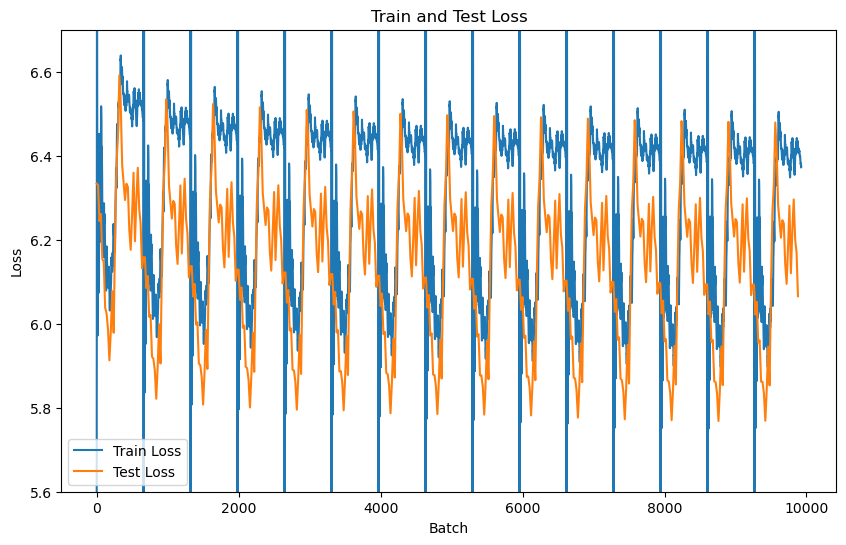

In [44]:
plot_losses(train_loss[4:-1], test_loss, batch_mod=20, ymin=5.6, ymax=6.7)

## Ensemble Prediction

### Load Pre-Trained Models

In [45]:
# Hyperparameters
window_size = 3
categorical_uniques = 55
numerical_dim = len(numerical_features)
embedding_dim = 10
dense_sizes = [512, 256, 128, 64, 32]

conv = ConvRNNModel(window_size, numerical_dim, categorical_uniques, embedding_dim, dense_sizes).to(device)
conv.load_state_dict(torch.load('Models/conv_model_fe_newloss.pth'))

lstm = LSTMModel(window_size, numerical_dim, embedding_dim, dense_sizes).to(device)
lstm.load_state_dict(torch.load('Models/lstm_model_fe_newloss.pth'))

rnn = RNNModelBase(window_size, numerical_dim, embedding_dim, categorical_uniques, dense_sizes).to(device)
rnn.load_state_dict(torch.load('Models/rnn_model_base_fe_newloss.pth'))

# Adjustments for transformer model
embedding_dim = 11
dense_sizes = [256, 128, 64, 32]

transformer = TransformerModel(window_size, numerical_dim, embedding_dim, categorical_uniques, dense_sizes).to(device)
transformer.load_state_dict(torch.load('Models/transformer_model_fe_newloss.pth'))

numerical_dim=45, embedding_dim=11
n_heads=8


<All keys matched successfully>

### Predict Test Set for All Models - Ensemble Model

In [46]:
# Create list of loaded models
models = [conv, lstm, rnn, transformer]
preds_df = pd.DataFrame()

targets = []

for model in models:
    model.eval()
    model_pred = []

    with torch.inference_mode():
        for data, target in tqdm(test_loader, desc="Predicting on test set", leave=False):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            #print(outputs.shape)        # torch.Size([4096, 1])
            model_pred.extend(outputs.squeeze().tolist())
            if model == models[0]:  # Record targets only once, using the first model
                targets.extend(target.squeeze().tolist())
            
    # Add model predictions to DataFrame
    preds_df[model.__class__.__name__] = model_pred

# Compute ensemble prediction and deviation from target
preds_df['EnsembleModel'] = preds_df.mean(axis=1)
preds_df['Target'] = targets
preds_df['Difference'] = preds_df['Target'] - preds_df['EnsembleModel']

preds_df

,ConvRNNModel,LSTMModel,RNNModelBase,TransformerModel,EnsembleModel,Target,Difference
0,0.563300,-0.296019,0.200024,0.465632,0.233234,2.609491,2.376257
1,-0.058434,-0.000960,-0.577068,0.254083,-0.095595,2.579689,2.675284
2,-0.022636,0.455261,-0.626436,0.684104,0.122573,-4.320145,-4.442718
3,-0.242727,0.672134,-0.162807,0.573757,0.210089,-6.480217,-6.690306
4,-0.449318,0.708703,-0.083408,0.498769,0.168686,-4.709959,-4.878646
...,...,...,...,...,...,...,...
547575,0.019717,-0.647075,-0.763822,-0.779761,-0.542735,-14.449954,-13.907219
547576,-0.979394,-1.472924,-1.415076,-1.367016,-1.308602,-22.670031,-21.361428
547577,-1.320145,-1.796684,-0.772917,-1.380256,-1.317501,-20.549892,-19.232392
547578,-0.460306,-0.896550,-0.446856,-0.597373,-0.600271,-17.949940,-17.349668


## Evaluating Models on Test Set

In [47]:
# Compute MAE for each model
print("MAE for each model:")
print(f"    ConvRNNModel: {abs(preds_df['Target'] - preds_df['ConvRNNModel']).mean():5f}")
print(f"    LSTMModel: {abs(preds_df['Target'] - preds_df['LSTMModel']).mean():5f}")
print(f"    RNNModelBase: {abs(preds_df['Target'] - preds_df['RNNModelBase']).mean():5f}")
print(f"    TransformerModel: {abs(preds_df['Target'] - preds_df['TransformerModel']).mean():5f}")
print(f"    EnsembleModel: {abs(preds_df['Target'] - preds_df['EnsembleModel']).mean():5f}")

MAE for each model:
    ConvRNNModel: 5.936930
    LSTMModel: 5.931735
    RNNModelBase: 5.950669
    TransformerModel: 5.919141
    EnsembleModel: 5.909938


### Plot Distributions of the Predictions

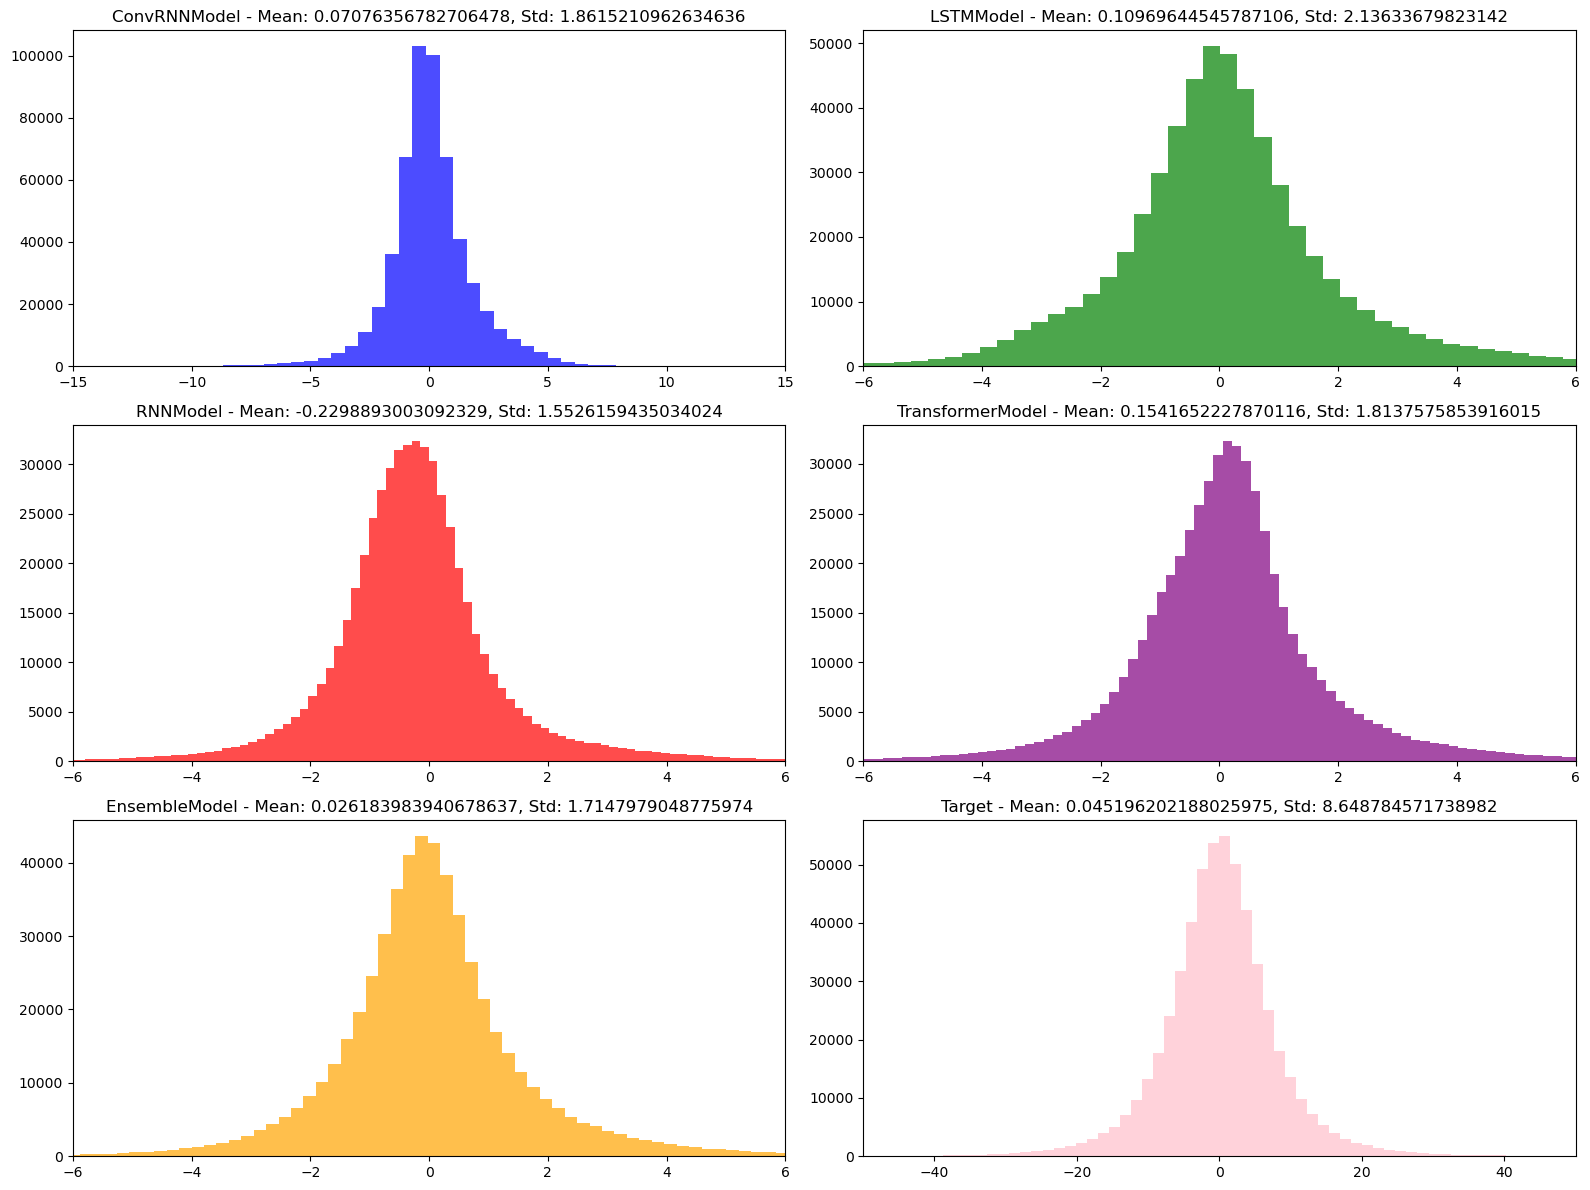

In [56]:
# Create a 3x2 plot of histograms for each model's predictions
fig, axs = plt.subplots(3, 2, figsize=(16, 12))
axs = axs.ravel()
axs[0].hist(preds_df['ConvRNNModel'], bins=250, color='blue', alpha=0.7)
axs[0].set_title(f"ConvRNNModel - Mean: {preds_df['ConvRNNModel'].mean()}, Std: {preds_df['ConvRNNModel'].std()}")
axs[0].set_xlim(-15, 15)

axs[1].hist(preds_df['LSTMModel'], bins=250, color='green', alpha=0.7)
axs[1].set_title(f"LSTMModel - Mean: {preds_df['LSTMModel'].mean()}, Std: {preds_df['LSTMModel'].std()}")
axs[1].set_xlim(-6, 6)

axs[2].hist(preds_df['RNNModelBase'], bins=150, color='red', alpha=0.7)
axs[2].set_title(f"RNNModel - Mean: {preds_df['RNNModelBase'].mean()}, Std: {preds_df['RNNModelBase'].std()}")
axs[2].set_xlim(-6, 6)

axs[3].hist(preds_df['TransformerModel'], bins=250, color='purple', alpha=0.7)
axs[3].set_title(f"TransformerModel - Mean: {preds_df['TransformerModel'].mean()}, Std: {preds_df['TransformerModel'].std()}")
axs[3].set_xlim(-6, 6)

axs[4].hist(preds_df['EnsembleModel'], bins=250, color='orange', alpha=0.7)
axs[4].set_title(f"EnsembleModel - Mean: {preds_df['EnsembleModel'].mean()}, Std: {preds_df['EnsembleModel'].std()}")
axs[4].set_xlim(-6, 6)

axs[5].hist(preds_df['Target'], bins=250, color='pink', alpha=0.7)
axs[5].set_title(f"Target - Mean: {preds_df['Target'].mean()}, Std: {preds_df['Target'].std()}")
axs[5].set_xlim(-50, 50)

plt.tight_layout()
plt.show()

In [50]:
# Check percentage of correct signs for predictions
preds_df['Sign'] = preds_df['EnsembleModel'] * preds_df['Target']
correct_signs = preds_df[preds_df['Sign'] > 0].shape[0]
total = preds_df.shape[0]
print(f"Correct signs: {correct_signs} out of {total} ({correct_signs/total*100:.2f}%)")

Correct signs: 303387 out of 547580 (55.41%)
